In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import comb
import time

np.random.seed(42)

# Statistical Hypothesis Testing

The intent of the hypothesis testing within data science is to determine if a result is significantly different from another. This is done by comparing a sample of data to a ***null hypothesis***. One way to view the null hypothesis is 'what we already know'. 

For example:
- Fair coin toss: Probability of each result should be 1/2
- Clairvoyance: Randomly guessing the suit of a card should be 1/4
- Medicine: Does a new procedure give better results than the convential means?
- Business: Did a marketing campaign bring in more revenue per person than another?

Signficiance is determined if **the probability that the observed event falls under the null hypothesis is less than a pre-selected threshold**. It is important that the threshold is selected before the experiment is done to avoid bias.

### Fair Coin example

We flip a coin 20 times to determine if it's a fair coin. We get a total of 14 heads. We want to test against a significance level of 5%. 

First we set up the null hypothesis probability mass function ([binomial](https://en.wikipedia.org/wiki/Binomial_distribution) for a coin flip) and set our significant level.

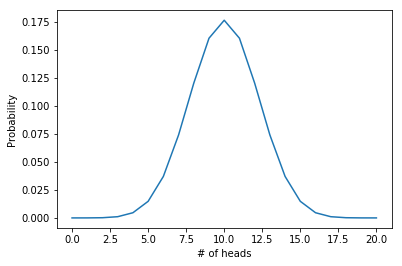

In [2]:
siglvl = 0.05

n = 20 
#Probability distribution for the number of heads observed for fair coin
fair_coin = [(comb(n,i)*(0.5**i)*(0.5**(n-i))) for i in range(0,n+1)]
assert(sum(fair_coin)==1) #dummy check to make sure distribution adds to 1

plt.plot(fair_coin)
plt.xlabel('# of heads')
plt.ylabel('Probability')
plt.show()

Then we determine the probability that our observation occurred.

Probability of at least 14 heads: 5.77%
Threshold significant level: 5.00%
We fail to reject the Null Hypothesis of a fair coin


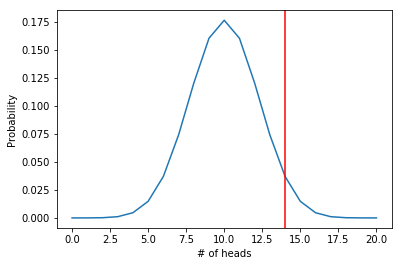

In [3]:
#Observation to test
H = 14

probH = sum(fair_coin[H:]) #Probability of flipping at least H heads

print('Probability of at least {0:d} heads: {1:0.2f}%'.format(H,probH*100))
print('Threshold significant level: {0:0.2f}%'.format(siglvl*100))
if probH <= siglvl: print('Reject Null Hypothesis of a fair coin')
if probH > siglvl: print('We fail to reject the Null Hypothesis of a fair coin')

plt.plot(fair_coin)
plt.xlabel('# of heads')
plt.ylabel('Probability')
plt.axvline(x=H, color = 'red')
plt.show()


Here we see that the probability of flipping at least 14 heads is ~5.77% which is greater than our significance level of 5% so we cannot reject the Null Hypothesis. However, if our observation is 15 heads, the probability drops to ~2% allowing us to reject the Null Hypothesis that the coin we're testing is fair.

The probability that an observation falls within the Null Hypothesis is called the **p-value**. Statistic packages in Python, such as [Scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html), come with the ability to calculate the p-value along with many other statistics and testing scores automatically. 

A coin flip follows a bionmial distribution with a probability of success of heads of 0.5. The [binom_test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html#scipy.stats.binom_test) function takes the number of successes, total trials, success probability, and type of test to determine the p-value. 

In [4]:
def P_value(x):
    return stats.binom_test(x, n=n, p = 0.5, alternative='greater')

print('P-value for H=10: {0:0.3f}'.format(P_value(10)))
print('P-value for H=14: {0:0.3f}'.format(P_value(14)))
print('P-value for H=15: {0:0.3f}'.format(P_value(15)))

P-value for H=10: 0.588
P-value for H=14: 0.058
P-value for H=15: 0.021


The p-value is also referred to as **Type I error**, the probability of a false positive. For statistical testing this mean we rejected the null hypothesis when in fact it is true. In hypothesis testing there are 4 potential outcomes summarized in the table below. The other potential error is failing to  reject the null hypothesis when in reality we should have. This is referred to as **Type II error**. Calculation of Type II error is more involved and will not be covered here. Although scipy.stats does not include a method to calculate it. There are many other [sources](https://en.wikipedia.org/wiki/Statistical_power#Software_for_power_and_sample_size_calculations) including R packages.

|                   |       **Not Rejecting** $H_0$   |      **Reject** $H_0$   |
|-------------------|:------------------------:|:-----------------------:|
| **$H_0$ True**    |     True Negative        | False Positive (Type I) |
| **$H_0$ False**   | False Negative (Type II) |     True Positive       |

Type I and Type II errors relate to the ***precision*** and ***recall*** of an experiment. With known data they can be defined as 

$$ \text{Precision} = \frac{true_p}{true_p + false_p} \ \ \ 
\text{Recall} = \frac{true_p}{true_p + false_n} $$

A low Type I error will lead to a high precision. Low Type II error leads to higher recall. In our work, we aim to maintain *reasonable* precision and recalls. Depending on the situation, one of these values may be vastly more important to maximize than the other.

Another way to think of precision and recall
- Precision: Few results, high classification accuracy
- Recall: Many results, lower classification accuracy

For example
- Spam filters err on the side of high precision to make sure important messages get through
- An advertising campaign may err on the side of recall, bringing in more people than the intended targetted demographic.
- First round, cheaper, medical tests may want higher recall to make sure we catch a disease early but more expensive follow ups want a high precision to prevent costly treatments when it's unnecessary

### Making Conclusions about the Population with a Small Sample

The example above was solved exactly however only 20 flips is a relatively small sample. We could 'flip the coin' 1000,10000,etc, to get a better understanding of the true 'fairness' but we may not have the time for that. When the sample size is small and there's uncertainty around the sample statistics **t-tests** can be a useful tool.

A t-test compares sample statistics of two samples or distributions, typically the mean, and determines if they're statistically significant from one another through a **t-score**. The t-score is calculated as:

$ t = \frac{\overline x - \mu_o}{std/\sqrt n}$

where
- $\  \overline x=sample\ mean$
- $\mu_o = null\ hypotheis\ mean$
- $std = stdev\ of\ sample$
- $n = sample\ size $



To properly use a t-test, we make a number of assumptions about the sample we're collecting. 

- The data we sample is independent with itself
- The data follows a Student-T's distribution.
- The variance is homogeneous

The Student-T distribution accounts for uncertainty in the standard deviation caused by small sampling size.

Deviating from the coin-flip example, we set up two normal distributions. A null standard and a small alternative sampling.

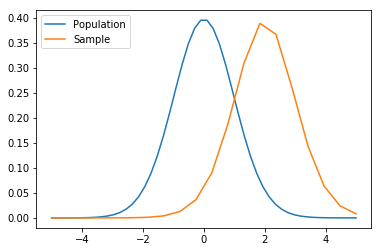

In [5]:
n_norm = 20

xnull = np.linspace(-5,5,50)
Null = stats.t.pdf(xnull, scale =1, df=50-1)
xalt = np.linspace(-5,5,n_norm)
Alt = stats.t.pdf(xalt, loc = 2,scale = 1,df=n_norm-1)

plt.plot(xnull,Null, label = 'Population')
plt.plot(xalt,Alt, label = 'Sample')
plt.legend()
plt.show()

We can extract the statistics from the distributions and use them to calculate a t-score 

In [6]:
null_mean = Null.mean()
alt_mean = Alt.mean()
alt_s = Alt.std()
t = np.abs((alt_mean-null_mean)/(alt_s/m.sqrt(n_norm)))
print(t)

0.10936704670138771


Here we solve for the t-score and then use the stats.t.sf function to calculate the P-value based on the t-score and degrees of freedom (n-1). There are also ubitquitous [tables](http://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf) for converting t-scores to P-values.

In [7]:
pval = (stats.t.sf(t, n_norm-1))
print(pval)

0.4570291077806963


The t-test is a special case where we have less than 30 samples or we don't know the standard deviation of the population. As our sample size increases however, all distributions trend towards normal ([Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)) and more test statistics open up that follow a similar method. 

## Bayesian Posterior Inference

The examples above take a frequentist approach, using direct sampling and disecrete values. However many of the test statistics in reality have a distribution as their solution. This is where **Bayesian Posterior Inference** comes in handy.

Recall Bayes Theorem based on a hypothesis H and evidence E.

$ P(H|E) = \frac{P(E|H)P(H)}{P(E)}$

$\text{where we refer to}$

- $P(H|E)\  \text{as the posterior}$

- $P(E|H)\  \text{as the likelihood}$

- $P(H)\  \text{as the prior}$

- $P(E)\  \text{as the marginal likelihood}$

In brief, the probability that our hypothesis H is true based on a set of evidence E is equivalent to the likelihood of the evidence occuring, assuming our hypothesis, times the probability of our hypothesis normalized to the probability of the evidence.

### Basic Example

Let's apply this to the results we got about with the coin flip. Based on the results of 20 flips we saw 14 heads. 
- From a fair coin, we'd have a p-value of 5.8%. That is, there's an 5.8% chance that this event would occur if the coin is fair, **P(E$_{14}$|H$_1$)** = 5.8%.
- For our prior, there's two possibilities, the coin is fair H$_1$ or the coin is not H$_2$
- Based on our result, we're skeptical that the coin is in fact fair and think that the chance of it being fair is 50%, **P(H$_1$)** = 50%, **P(H$_2$)** = 50%
- We can draw up an unfair coin and calculate **P(E$_{14}$|H$_2$)** = 1

Probability of 14 heads with fair coin 0.058
Probability of 14 heads with unfair coin 0.608


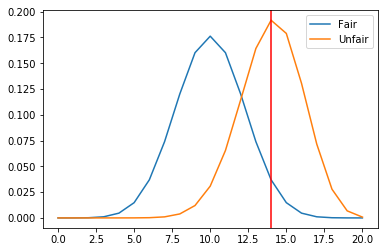

In [8]:
n = 20
unfair = 0.7
H = 14

fair_coin = [(comb(n,i)*(0.5**i)*(0.5**(n-i))) for i in range(0,n+1)]
unfair_coin = [(comb(n,i)*(unfair**i)*((1-unfair)**(n-i))) for i in range(0,n+1)]

PE_H1 = sum(fair_coin[H:]) #[H:] if H>max [:H] if H<max
PE_H2 = sum(unfair_coin[H:]) #[H:] if H>max [:H] if H<max
if PE_H2 > 1: PE_H2 =1
    
print('Probability of {0:d} heads with fair coin {1:0.3f}'.format(H,PE_H1))
print('Probability of {0:d} heads with unfair coin {1:0.3f}'.format(H,PE_H2))
plt.plot(fair_coin, label ='Fair')
plt.plot(unfair_coin, label ='Unfair')
plt.legend()
plt.axvline(x=H, color = 'red')
plt.show()

Using Bayes Theorem we have

$ P(H_1|E_{14}) = \frac{P(E_{14}|H_1)P(H_1)}{P(E_{14}|H_1)P(H_1)+P(E_{14}|H_2)P(H_2)}$

$$or$$

In [9]:
#Set P(H) for each potential hypothesis
PH1 = 0.5
PH2 = 1-PH1

#Calculate P(H|E)
PH1_E = PE_H1*PH1/(PE_H1*PH1+PE_H2*PH2)

print('P(H_1|E_14) = {0:0.2f}% chance the coin is fair'.format(PH1_E*100))

P(H_1|E_14) = 8.66% chance the coin is fair


Standard probability exercises, like picking a colored marble from two different pots provide other good [examples](https://en.wikipedia.org/wiki/Bayesian_inference#Examples) of basic use.

### Bayes Inference for Real Time statistics

For many applications in data science, our data set is ever expanding. We're constantly getting another day's worth of data that needs to be incorporated into our predictions. While we *could* wait around until enough data has been collected, we often need to make decisions before we have the full data available. This numerical approach is fine for small samples but we'll want a more rigourous way for streaming data, an analytical solution.
As $P(E) = \int{}P(E|H_x)P(H_x)dx$ Bayes Theorem can be expressed as

$$ P(H|E) = \frac{P(E|H)P(H)}{\int{}P(E|H_x)P(H_x)dH_x}$$

which will make future math much easier. What we're looking for is a way to solve for P(H|E) analytically. 

For this, we'll examine ***conjugate pairs***. In Bayesian statistics, if the posterior distribution, P(H|E), is in the same family as the prior, P(H), they form a ***conjugate distribution*** and the prior is a ***conjugate prior*** of the likelihood function. In order to get a clean analytical solution, we aim to match a conjugate prior to our known sample distribution (likelihood). A full table of Conjugate distributions can be found [here](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)

As shown above, a coin flip follows a binomial distribution. 

$$P(E|H) = C(n,k)*p^{k}*(1-p)^{n-k}$$

As seen in the table about the prior conjugate will be a beta function.

$$P(H) = \frac{p*{\alpha-1}*(1-p)^{\beta-1}}{B(\alpha,\beta)}$$

Plugging the likelihood and prior into the integral form of Bayes Theorem and solving results in

$$ P(H|E) = \frac{p^{k+\alpha-1}*(1-p)^{n-k+\beta-1}}{B(k+\alpha,n-k+\beta)}$$

Where alpha and beta are the number of successes and failures respectively

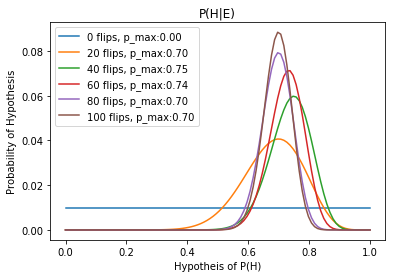

In [10]:
alpha=1
beta=1

pH = 0.7
trials = 100
x = np.linspace(0,1,100)
ys = [stats.beta.pdf(x,alpha,beta)]

interval = int(trials/5)

for i in range(1,trials+1):
    flip = np.random.uniform(0,1) 
    if flip <=pH: alpha +=1
    if flip >pH: beta +=1
        
    if i%interval==0:
        ys.append(stats.beta.pdf(x,alpha,beta))

for i in range(len(ys)):
    max_p = x[ys[i].argmax()]
    plt.plot(x,ys[i]/sum(ys[i]),label = '{0:d} flips, p_max:{1:0.2f}'.format(i*interval,max_p))
    plt.title('P(H|E)')

    plt.ylabel('Probability of Hypothesis')
plt.xlabel('Hypotheis of P(H)')
plt.legend()
plt.show()

The above plot shows gives the probability distribution that the coin is weighted in a specific way. Here we see that the maximum of the distribution is ~0.7 the weighting we set for the sample

How does this compare to our original hypothesis testing? We discussed how the p-value is the probability that an observation will occur in the null hypothesis. 

We can take the distribution found above for 20 flips and use that to test the likelihood of a given hypothesis. In this case we test the case of 0.5.

Probability of 0.50 weight after 20 flips: 0.85%


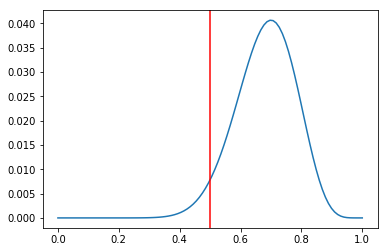

In [11]:
hypothesis_weight = 0.5
flips = 20 #keeps flips as multiples of the interval above

x = np.linspace(0,1,100)
idx = int(flips/interval)
flip_dist = ys[idx]/sum(ys[idx])
xidx = (np.abs(x-hypothesis_weight)).argmin()+1

p_fair = flip_dist[xidx]*100
print('Probability of {0:0.2f} weight after {1:d} flips: {2:0.2f}%'.format(hypothesis_weight,idx*interval,p_fair))
plt.plot(x,flip_dist)
plt.axvline(x=hypothesis_weight, color = 'red')
plt.show()

Now that we have a posterior distribution, we could use it as a random sampling resevoir for future experiments. Below we generate 100 coins and run the 20 flip trial on those coins, recapitulating the probability distribution for the number of heads. Like we had at the beginning.

Probability of 14 heads with fair coin 0.058
Probability of 14 heads with unfair coin 0.263


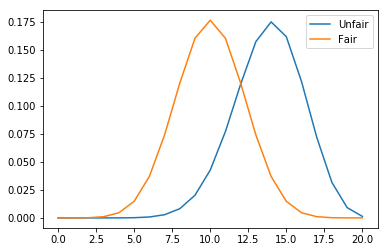

In [12]:
coins_to_test = 100
flips = 20

weights = stats.beta.rvs(alpha, beta, size=coins_to_test)

x = range(0,flips+1)
trials = []
for w in weights:
    unfair_coin = [(comb(flips,i)*(w**i)*((1-w)**(flips-i))) for i in range(0,flips+1)]
    trials.append(unfair_coin)
    
averaged = np.sum(np.array(trials),axis=0)/coins_to_test

PE_H1 = sum(fair_coin[H:]) #[H:] if H>max [:H] if H<max
PE_H2 = sum(unfair_coin[H:]) #[H:] if H>max [:H] if H<max
if PE_H2 > 1: PE_H2 =1
    
print('Probability of {0:d} heads with fair coin {1:0.3f}'.format(H,PE_H1))
print('Probability of {0:d} heads with unfair coin {1:0.3f}'.format(H,PE_H2))

plt.plot(averaged, label = 'Unfair')
plt.plot(fair_coin, label = 'Fair')
plt.legend()
plt.show()


## Summary

- Hypothesis testing is critical to determine if data is significantly different from a null hypothesis or from other data.
- The P-value is a metric to determine the false positive, or Type I error rate. The accepted threshold, significance level, should be set before P-value is found.
- t-tests are used when we have little data (<30 pts) or don't know the standard deviation of the population
- Bayesian inference finds analytical solutions to hypothesis distributions. Finding conjugate priors are crucial for finding a clean, analytical solution
- Both approaches assume, at scale, homogeneous normal data